# EXCEED Prolific Study - Pre-launch Sanity Checks

This notebook is designed to analyze the feedback results that were collected via https://github.com/alemoraru/exceed-project-validation. The validation repository was designed for evaluating the effectiveness of our prompt templates and chosen candidate language models in rephrasing error messages for buggy code snippets. The web application allows users to select different models and prompt styles, generate improved error messages, and provide feedback on their quality. The feedback is collected in a CSV file, which is then analyzed in this notebook.

Both authors of the EXCEED project have rated the generated error messages on the validation platform while changing the following parameters:
- **Model**: The language model used to generate the error messages (either `qwen2.5:7b` or `granite3:3:8b`).
- **Prompt Style**: The style of the prompt used to generate the error messages (either `pragmatic` or `contingent`).
- **Code Snippet + Error Message**: The four code snippets which were selected for the main study (see the previous notebooks for details, i.e. `01_...`, `02_...` and `03_...` ones).

## Step 0: Install Required Python Libraries

In [78]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 1: Load the Feedback Data

The feedback data CSV has the following headers (columns):
- `snippetId`: The ID of the code snippet (i.e., `snippetA`, `snippetB`, `snippetC`, or `snippetD`).
- `snippetName`: A more user-friendly name to distinguish the code snippets:
     - `unterminated_string_syntax_error.py`
     - `name_error.py`
     - `annotation_type_error.py`
     - `subscriptable_syntax_error.py`
- `errorMessageStyle`: The style of the error message (either `pragmatic` or `contingent`).
- `model`: The language model used to generate the error message (e.g., `qwen2.5:7b` or `granite3:3:8b`).
- `timestamp`: The timestamp when the feedback was submitted for this error message.
- `comprehensible`: Is the error message easy to understand (TRUE or FALSE).
- `correct`: Does the error message correctly explain the problem (TRUE or FALSE).
- `improvement`: Is the error message better than the standard one (TRUE or FALSE).
- `hasHint`: Does the error message contain a hint for a possible fix (TRUE or FALSE).
- `hintCorrect`: Is the suggested fix in the error message correct (TRUE or FALSE).
- `adheresToGuidelines`: Does the error message follow the prompt's guidelines (TRUE or FALSE).

In [79]:
import pandas as pd

# Set the path to the CSV file which contains the feedback results
file_path = "../data/feedback_example_results.csv"

# Load the data into a DataFrame
df = pd.read_csv(file_path)

## Step 2: Plot the Feedback Data

First, we define a reusable function that is able to plot the feedback data in a stacked bar chart format. The function will create one figure per code snippet, showing the counts of TRUE and FALSE responses for each question, grouped by model and prompt style.

### Step 2.1: Define the Plotting Function

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Belong to the CSV file headers
QUESTIONS = [
    "comprehensible",
    "correct",
    "improvement",
    "hasHint",
    "hintCorrect",
    "adheresToGuidelines"
]


def _to_bool(v):
    s = str(v).strip().lower()
    if s in ("true", "t", "1", "yes", "y"):
        return True
    if s in ("false", "f", "0", "no", "n"):
        return False
    return v


def plot_stacked_bar_charts(dataframe=None, file_path=None, snippets=None, questions=QUESTIONS,
                            figsize=(14, 8), gap_between_questions=0.05, group_gap=0.6, bar_width=0.18,
                            save_folder=None, ytick_step=1, annotate_threshold=1.5):
    """
    Plots one figure per snippetId. For each model and question:
      - Pragmatic bar stacked (TRUE bottom, FALSE on top) positive
      - Contingent bar stacked (TRUE near-zero, FALSE further down) negative
    Additional features:
      - numeric labels on every non-zero stacked segment
      - consistent colors across models/styles:
           pragmatic TRUE  = green ('#2ca02c')
           pragmatic FALSE = red   ('#d62728')
           contingent TRUE = blue  ('#1f77b4')
           contingent FALSE = orange('#ff7f0e')
      - model name labels appear below the title, centered over each model group
    """
    if dataframe is None:
        if file_path is None:
            raise ValueError("Either dataframe or file_path must be provided.")
        dataframe = pd.read_csv(file_path)
    dataf = dataframe.copy()

    # normalize booleans
    for q in questions:
        if q in dataf.columns:
            dataf[q] = dataf[q].map(_to_bool)
            try:
                dataf[q] = dataf[q].astype(bool)
            except Exception:
                pass

    models = sorted(dataf['model'].dropna().unique())
    if len(models) == 0:
        raise ValueError("No models found in dataframe.")

    unique_snips = sorted(dataf['snippetId'].dropna().unique())
    if snippets is None:
        snippets = unique_snips
    else:
        snippets = [s for s in snippets if s in unique_snips]
        if len(snippets) == 0:
            raise ValueError("None of the requested snippets exist in the dataframe.")

    n_models = len(models)
    n_q = len(questions)
    step = bar_width + gap_between_questions

    # fixed color mapping
    color_map = {
        'prag_true': '#2ca02c',
        'prag_false': '#d62728',
        'cont_true': '#1f77b4',
        'cont_false': '#ff7f0e'
    }

    for snip in snippets:
        # compute counts
        counts = {m: {'pragmatic': {'true': [], 'false': []}, 'contingent': {'true': [], 'false': []}} for m in models}
        for m in models:
            for q in questions:
                sel_pr = dataf[
                    (dataf['snippetId'] == snip) & (dataf['model'] == m) & (dataf['errorMessageStyle'] == 'pragmatic')]
                sel_ct = dataf[
                    (dataf['snippetId'] == snip) & (dataf['model'] == m) & (dataf['errorMessageStyle'] == 'contingent')]
                true_pr = int(sel_pr[q].sum()) if q in sel_pr.columns else 0
                total_pr = len(sel_pr)
                false_pr = total_pr - true_pr
                true_ct = int(sel_ct[q].sum()) if q in sel_ct.columns else 0
                total_ct = len(sel_ct)
                false_ct = total_ct - true_ct
                counts[m]['pragmatic']['true'].append(true_pr)
                counts[m]['pragmatic']['false'].append(false_pr)
                counts[m]['contingent']['true'].append(true_ct)
                counts[m]['contingent']['false'].append(false_ct)

        # compute x positions and group centers for model label placement
        x_positions = []
        group_centers = []
        base = 0.0
        for i in range(n_models):
            group_base = base + i * (n_q * step + group_gap)
            # center of group = average of first and last question center
            first = group_base + 0 * step
            last = group_base + (n_q - 1) * step
            group_centers.append((first + last) / 2.0)
            for j in range(n_q):
                x_positions.append(group_base + j * step)
        x_positions = np.array(x_positions)

        fig, ax = plt.subplots(figsize=figsize)
        # plot bars and annotate
        for i, m in enumerate(models):
            for j, q in enumerate(questions):
                idx = i * n_q + j
                x = x_positions[idx]

                # pragmatic positive stacked
                t_pr = counts[m]['pragmatic']['true'][j]
                f_pr = counts[m]['pragmatic']['false'][j]
                bottom = 0.0
                if t_pr > 0:
                    ax.bar(x, t_pr, width=bar_width, bottom=bottom, color=color_map['prag_true'])
                    # annotate in center of segment
                    y_center = bottom + t_pr / 2.0
                    if t_pr >= annotate_threshold:
                        ax.text(x, y_center, str(t_pr), ha='center', va='center', color='white', fontsize=8)
                    else:
                        ax.text(x, y_center, str(t_pr), ha='center', va='center', color='black', fontsize=8)
                    bottom += t_pr
                if f_pr > 0:
                    ax.bar(x, f_pr, width=bar_width, bottom=bottom, color=color_map['prag_false'])
                    y_center = bottom + f_pr / 2.0
                    if f_pr >= annotate_threshold:
                        ax.text(x, y_center, str(f_pr), ha='center', va='center', color='white', fontsize=8)
                    else:
                        ax.text(x, y_center, str(f_pr), ha='center', va='center', color='black', fontsize=8)
                    bottom += f_pr

                # contingent negative stacked: draw TRUE then FALSE downward
                t_ct = counts[m]['contingent']['true'][j]
                f_ct = counts[m]['contingent']['false'][j]
                bottom_neg = 0.0
                if t_ct > 0:
                    ax.bar(x, -t_ct, width=bar_width, bottom=bottom_neg, color=color_map['cont_true'])
                    y_center = bottom_neg - t_ct / 2.0
                    if t_ct >= annotate_threshold:
                        ax.text(x, y_center, str(t_ct), ha='center', va='center', color='white', fontsize=8)
                    else:
                        ax.text(x, y_center, str(t_ct), ha='center', va='center', color='black', fontsize=8)
                    bottom_neg -= t_ct
                if f_ct > 0:
                    ax.bar(x, -f_ct, width=bar_width, bottom=bottom_neg, color=color_map['cont_false'])
                    y_center = bottom_neg - f_ct / 2.0
                    if f_ct >= annotate_threshold:
                        ax.text(x, y_center, str(f_ct), ha='center', va='center', color='white', fontsize=8)
                    else:
                        ax.text(x, y_center, str(f_ct), ha='center', va='center', color='black', fontsize=8)
                    bottom_neg -= f_ct

        # draw delimiters
        for i in range(1, n_models):
            delim_x = base + i * (n_q * step + group_gap) - group_gap / 2
            ax.axvline(x=delim_x, color='gray', linestyle='--', linewidth=1.0)

        # x ticks and vertical labels
        tick_positions = []
        tick_labels = []
        for i, m in enumerate(models):
            group_base = base + i * (n_q * step + group_gap)
            for j, q in enumerate(questions):
                tick_positions.append(group_base + j * step)
                tick_labels.append(q)
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=90, ha='center', va='top')
        ax.tick_params(axis='x', pad=15)

        # model labels above the plot: centered over each group
        # get current ylim to position labels above the bars
        y_top = ax.get_ylim()[1]
        # Move the title higher using y=1.18 in axes coordinates (higher than before)
        ax.set_title(f"Snippet: {snip} — Counts by question (stacked TRUE/FALSE) per model & error message style",
                     y=1.18)
        label_offset = 0.08 * (y_top if y_top > 0 else 1)
        for i, m in enumerate(models):
            ax.text(group_centers[i], y_top + label_offset, m, ha='center', va='bottom', fontsize=10, fontweight='bold')

        # legend for the 4 segment types (generic, not per-model)
        legend_handles = [
            mpatches.Patch(color=color_map['prag_true'], label='Pragmatic TRUE'),
            mpatches.Patch(color=color_map['prag_false'], label='Pragmatic FALSE'),
            mpatches.Patch(color=color_map['cont_true'], label='Contingent TRUE'),
            mpatches.Patch(color=color_map['cont_false'], label='Contingent FALSE'),
        ]
        ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(1.01, 1))

        # y-axis ticks symmetric based on stacked totals
        max_pos = 0
        max_neg = 0
        for m in models:
            pos_totals = np.array(counts[m]['pragmatic']['true']) + np.array(counts[m]['pragmatic']['false'])
            neg_totals = np.array(counts[m]['contingent']['true']) + np.array(counts[m]['contingent']['false'])
            if pos_totals.size > 0:
                max_pos = max(max_pos, pos_totals.max())
            if neg_totals.size > 0:
                max_neg = max(max_neg, neg_totals.max())
        max_val = max(max_pos, max_neg)
        max_tick = int(np.ceil(max_val / ytick_step) * ytick_step) if max_val > 0 else ytick_step
        ticks = np.arange(-max_tick, max_tick + 1, ytick_step)
        labels = [str(abs(int(t))) if t != 0 else '0' for t in ticks]
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)

        ax.axhline(0, color='black', linewidth=0.8)
        ax.set_ylabel("Count of responses\n->TRUE / FALSE stacked\n->pragmatic up / contingent down")
        ax.set_title(f"Snippet: {snip} — Counts by question (stacked TRUE/FALSE) per model & error message style",
                     y=1.18)

        ax.grid(axis='y', linestyle=':', linewidth=0.6)
        plt.tight_layout()
        if save_folder:
            import os
            os.makedirs(save_folder, exist_ok=True)
            save_path = os.path.join(save_folder, f"feedback_snippet_{snip}.png")
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()


### Step 2.2: Plot the Feedback Data (Example CSV)

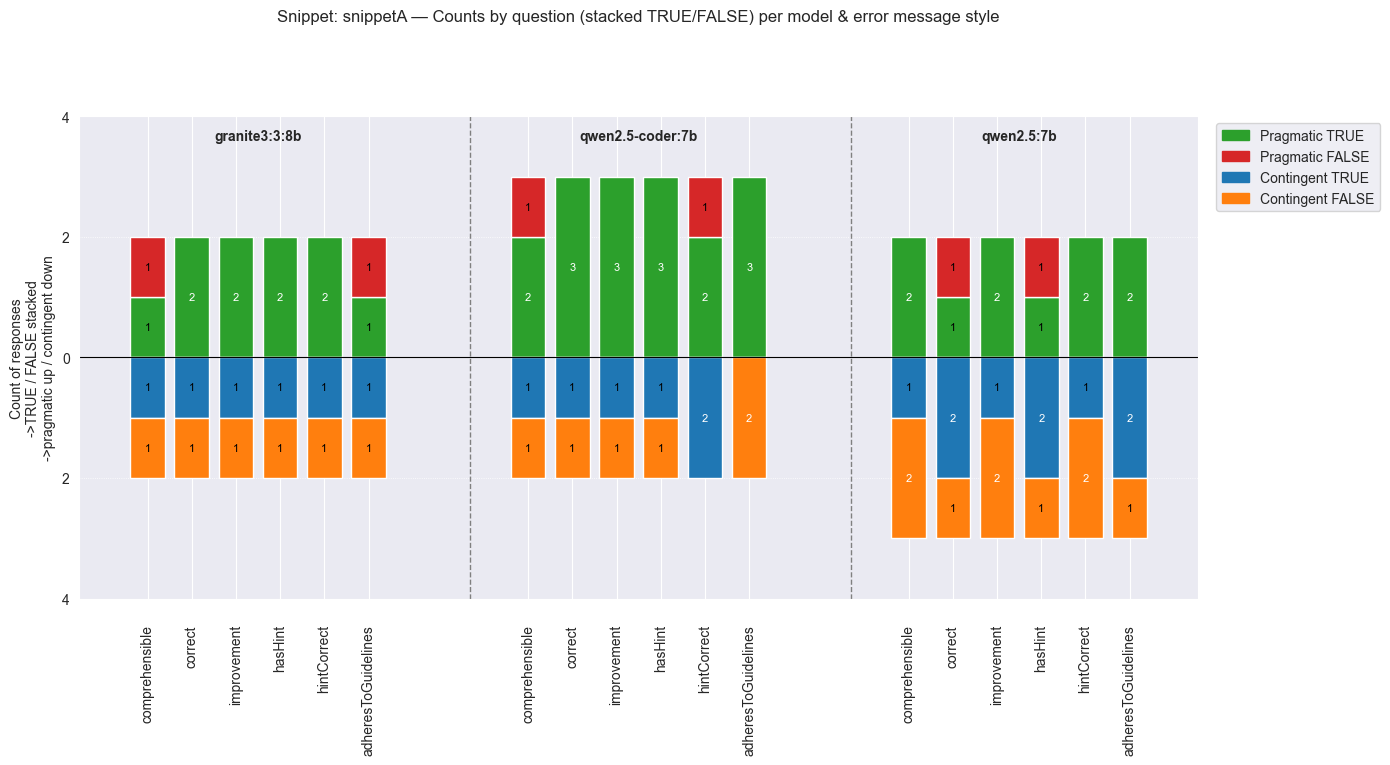

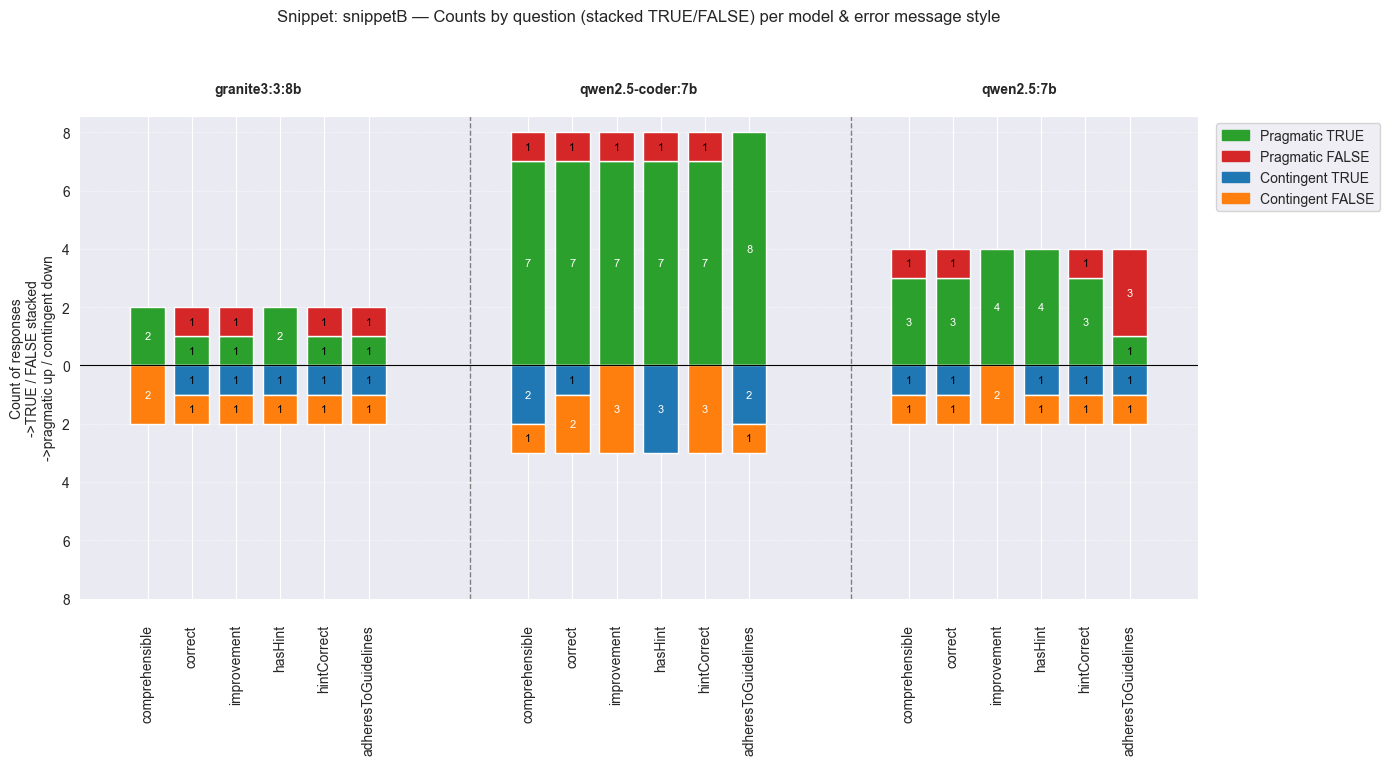

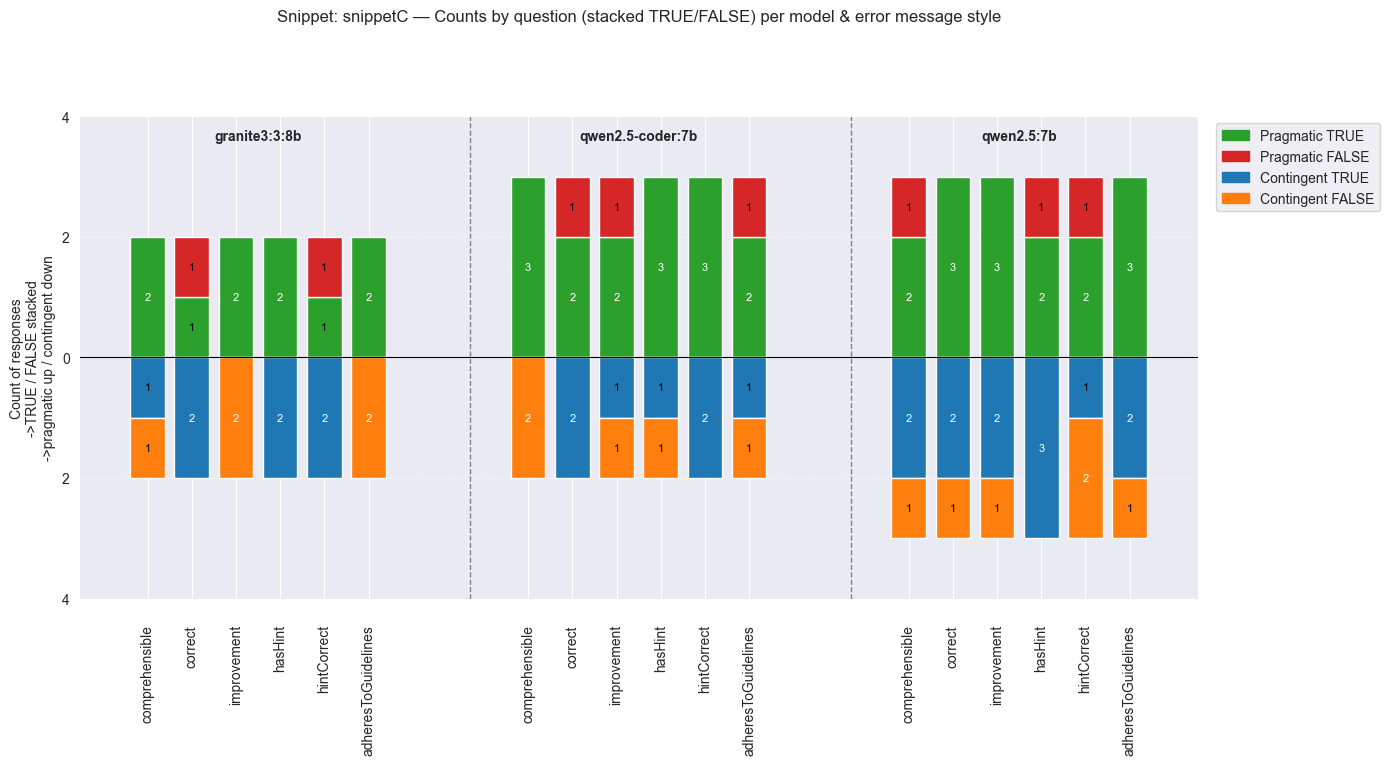

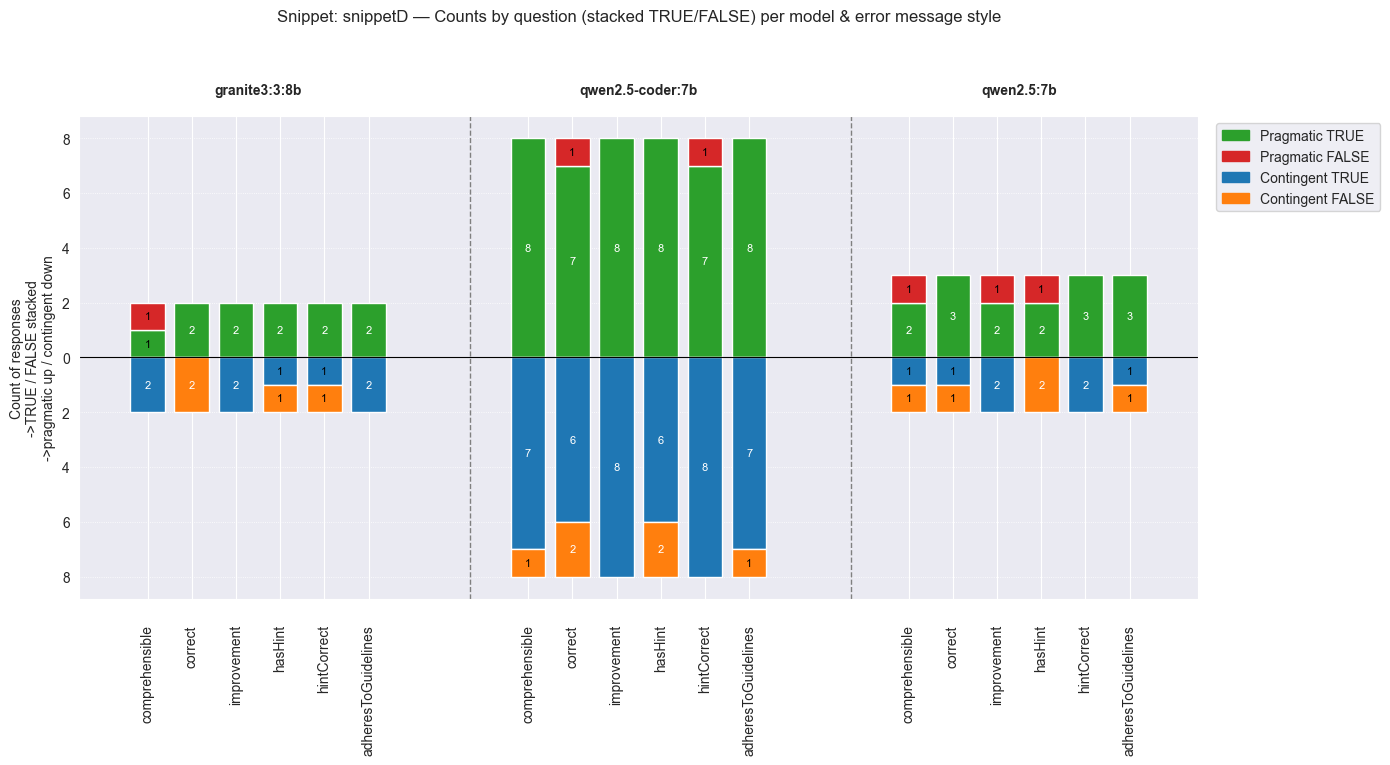

In [81]:
# Run demo on sample data
plot_stacked_bar_charts(dataframe=df, ytick_step=2)